In [1]:
import numpy as np
X_train = np.array([
    [0, 1, 1],
    [0, 0, 1],
    [0, 0, 0],
    [1, 1, 0]
])
Y_train = ['Y', 'N', 'Y', 'Y']
X_test = np.array([[1, 1, 0]])

#### starting with prior, first group the data by label and record their indices by classes

In [2]:
def get_label_indices(labels):
    """
    @param labels: list of labels
    @return: dict, {class1: [indices], class2: [indices]}
    """
    
    from collections import defaultdict
    label_indices = defaultdict(list)
    for index, label in enumerate(labels):
        label_indices[label].append(index)
    return label_indices

In [3]:
# test the function
label_indices = get_label_indices(Y_train)
print('label_indices:\n', label_indices)

label_indices:
 defaultdict(<class 'list'>, {'Y': [0, 2, 3], 'N': [1]})


In [4]:
# with label_indices, next calculate the prior
def get_prior(label_indices):
    """
    Compute prior based on training samples
    @param label_indices: grouped sample indices by class
    @return: dictionary, with class label as key, corresponding 
    prior as the value
    """
    prior = {label: len(indices) for label, indices in label_indices.items()}
    total_count = sum(prior.values())
    for label in prior:
        prior[label] /= total_count
    return prior

In [5]:
# look at computed prior
prior = get_prior(label_indices)
print('Prior:', prior)

Prior: {'Y': 0.75, 'N': 0.25}


In [6]:
# likelihood. (conditional probability, P(feature | class))
def get_likelihood(features, label_indices, smoothing=0):
        
    """
    Compute likelihood based on training samples
    @param features: matrix of features
    @param label_indices: grouped sample indices by class
    @param smoothing: integer, additive smoothing parameter
    @return: dictionary, with class as key, corresponding 
    conditional probability P(feature|class) vector 
    as value
    """
    
    likelihood = {}
    for label, indices in label_indices.items():
        likelihood[label] = features[indices, :].sum(axis=0) + smoothing
        total_count = len(indices)
        likelihood[label] = likelihood[label] / (total_count + 2 * smoothing)
    
    return likelihood

In [7]:
smoothing = 1
likelihood = get_likelihood(X_train, label_indices, smoothing)
print('Likelihood:\n', likelihood)

Likelihood:
 {'Y': array([0.4, 0.6, 0.4]), 'N': array([0.33333333, 0.33333333, 0.66666667])}


In [8]:
# with prior and likelihood we can compute posterior
def get_posterior(X, prior, likelihood):
    """
        Compute posterior of testing samples, based on prior and 
        likelihood
        @param X: testing samples
        @param prior: dictionary, with class label as key, 
        corresponding prior as the value
        @param likelihood: dictionary, with class label as key, 
        corresponding conditional probability
        vector as value
        @return: dictionary, with class label as key, corresponding 
        posterior as value
    """
    posteriors = []
    for x in X:
        # posterior is proportional to prior * likelihood
        posterior = prior.copy()
        for label, likelihood_label in likelihood.items():
            for index, bool_value, in enumerate(x):
                posterior[label] *= likelihood_label[index] if bool_value else (1 - likelihood_label[index])
        # normalize so that all sums upto 1
        sum_posterior = sum(posterior.values())
        for label in posterior:
            if posterior[label] == float('inf'):
                posterior[label] = 1.0
            else:
                posterior[label] /= sum_posterior
            posteriors.append(posterior.copy())
        return posteriors

In [9]:
posterior = get_posterior(X_test, prior, likelihood)
print('Posterior:\n', posterior)

Posterior:
 [{'Y': 0.9210360075805433, 'N': 0.00925925925925926}, {'Y': 0.9210360075805433, 'N': 0.07896399241945673}]


#### Implementing naive bayes with scikit-learn

In [10]:
from sklearn.naive_bayes import BernoulliNB

In [11]:
# initialize model with smoothing=1 (alpha in sklearn) and prior learned 
# from training set (fit_prior=True in sklearn)
clf = BernoulliNB(alpha=1.0, fit_prior=True)

In [12]:
clf.fit(X_train, Y_train)

BernoulliNB()

In [13]:
# predicted probability results with predict proba method
pred_prob = clf.predict_proba(X_test)
print('[scikit-learn] Predicted probabilities:\n', pred_prob)

[scikit-learn] Predicted probabilities:
 [[0.07896399 0.92103601]]


In [14]:
# directly acquire the predicted class with predict method (0.5 is deafult threshold)
pred = clf.predict(X_test)
print('[scikit-learn] Prediction:', pred)

[scikit-learn] Prediction: ['Y']


### building a movie recommendation system with naive bayes

In [34]:
# import necessary modules
import numpy as np
from collections import defaultdict
data_path = 'D:/ml-1m/ml-1m/ratings.dat'
n_users = 6040
n_movies = 3706

In [35]:
data = np.zeros([n_users, n_movies], dtype=np.float32)
print(data.shape)

(6040, 3706)


In [44]:
# function to load rating data
def load_rating_data(data_path, n_users, n_movies):
    """
    Load rating data from file and also return the number of 
    ratings for each movie and movie_id index mapping
    @param data_path: path of the rating data file
    @param n_users: number of users
    @param n_movies: number of movies that have ratings
    @return: rating data in the numpy array of [user, movie]; 
    movie_n_rating, {movie_id: number of ratings};
    movie_id_mapping, {movie_id: column index in 
    rating data}
    """
    data = np.zeros([n_users, n_movies], dtype=np.float32)
    movie_id_mapping = {}
    movie_n_rating = defaultdict(int)
    
    with open(data_path, 'r') as file:
        for line in file.readlines()[1:]:
            user_id, movie_id, rating, _ = line.split("::")
            user_id = int(user_id) - 1
            if movie_id not in movie_id_mapping:
                movie_id_mapping[movie_id] = len(movie_id_mapping)
            rating = int(float(rating))
            data[user_id, movie_id_mapping[movie_id]] = rating
            if rating > 0:
                movie_n_rating[movie_id] += 1
    return data, movie_n_rating, movie_id_mapping

In [45]:
# load data using this function
data, movie_n_rating, movie_id_mapping = load_rating_data(data_path, n_users, n_movies)

In [46]:
# analyze data distribution
def display_distribution(data):
    values, counts = np.unique(data, return_counts=True)
    for value, count in zip(values, counts):
        print(f'Number of rating {int(value)}: {count}')

In [47]:
display_distribution(data)

Number of rating 0: 21384032
Number of rating 1: 56174
Number of rating 2: 107557
Number of rating 3: 261197
Number of rating 4: 348971
Number of rating 5: 226309


###### since most ratings are unknown, we take movie with most known ratings as our target movie

In [48]:
movie_id_most, n_rating_most = sorted(movie_n_rating.items(), key=lambda d: d[1], reverse=True)[0]
print(f'Movie ID {movie_id_most} has {n_rating_most} ratings')

Movie ID 2858 has 3428 ratings


###### movie id 260 is the target movie, ratings of rest of the movies are signals. we construct the dataset accordingly

In [49]:
X_raw = np.delete(data, movie_id_mapping[movie_id_most], axis=1)
Y_raw = data[:, movie_id_mapping[movie_id_most]]

###### if samples with movie id 260 doesn't have ratings, discard those

In [50]:
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]
print("Shape of X:", X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (3428, 3705)
Shape of Y: (3428,)


###### distribution of the target movie ratings

In [51]:
display_distribution(Y)

Number of rating 1: 83
Number of rating 2: 134
Number of rating 3: 358
Number of rating 4: 890
Number of rating 5: 1963


###### movies with rating > 3 are considered as recommended

In [52]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1
n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f'{n_pos} positive samples and {n_neg} negative samples')

2853 positive samples and 575 negative samples


###### split the dataset 

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [54]:
print(len(Y_train), len(Y_test))

2742 686


###### MultinomialNB works well with integers

In [55]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)

MultinomialNB()

In [56]:
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[0:10])

[[7.50487439e-23 1.00000000e+00]
 [1.01806208e-01 8.98193792e-01]
 [3.57740570e-10 1.00000000e+00]
 [1.00000000e+00 2.94095407e-16]
 [1.00000000e+00 2.49760836e-25]
 [7.62630220e-01 2.37369780e-01]
 [3.47479627e-05 9.99965252e-01]
 [2.66075292e-11 1.00000000e+00]
 [5.88493563e-10 9.99999999e-01]
 [9.71326867e-09 9.99999990e-01]]


In [57]:
prediction = clf.predict(X_test)
print(prediction[:10])

[1. 1. 1. 0. 0. 0. 1. 1. 1. 1.]


In [58]:
accuracy = clf.score(X_test, Y_test)
print(f'The accuracy is: {accuracy*100:.1f}%')

The accuracy is: 71.6%


#### Evaluating classification performance

In [59]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

[[ 60  47]
 [148 431]]


In [63]:
# precision, recall, f1 score
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(Y_test, prediction, pos_label=1)

0.9016736401673641

In [61]:
recall_score(Y_test, prediction, pos_label=1)

0.7443868739205527

In [62]:
f1_score(Y_test, prediction, pos_label=1)

0.815515610217597

###### obtain precision, recall and f1 score for each class

In [65]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

         0.0       0.29      0.56      0.38       107
         1.0       0.90      0.74      0.82       579

    accuracy                           0.72       686
   macro avg       0.60      0.65      0.60       686
weighted avg       0.81      0.72      0.75       686



###### ROC curve

In [66]:
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.1, 0.05)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            # if truth and prediction are both 1
            if y == 1:
                true_pos[i] += 1
            # if truth is 0 while prediction is 1
            else:
                false_pos[i] += 1
        else:
            break

###### calculate the true and false positive rates

In [67]:
n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]

###### plot ROC curve with matplotlib

No handles with labels found to put in legend.


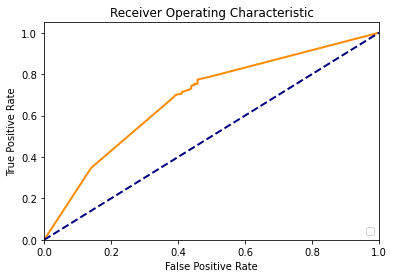

In [68]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, 
color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

###### Exact AUC of our model

In [69]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob)

0.6857375752586637

#### Tuning Model

In [71]:
# split() method from StratifiedKFold divides the data in chunks with preserved class distribution
from sklearn.model_selection import StratifiedKFold
k = 5
k_fold = StratifiedKFold(n_splits=k, random_state=None)

In [72]:
smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}

In [74]:
for train_indices, test_indices in k_fold.split(X, Y):
    X_train, X_test = X[train_indices], X[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train, Y_train)
            prediction_prob = clf.predict_proba(X_test)
            pos_prob = prediction_prob[:, 1]
            auc = roc_auc_score(Y_test, pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)

###### Results

In [75]:
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f'    {smoothing}        {fit_prior}       {auc/k:.5f}')

    1        True       0.65647
    1        False       0.65708
    2        True       0.65795
    2        False       0.65823
    3        True       0.65740
    3        False       0.65801
    4        True       0.65808
    4        False       0.65795
    5        True       0.65814
    5        False       0.65694
    6        True       0.65663
    6        False       0.65719


###### The (2, False) set enables the best averaged AUC at 0.65823
###### finally, retrain the model with best set of hyperparameters (2, False) and compute AUC

In [76]:
clf = MultinomialNB(alpha=2.0, fit_prior=False)
clf.fit(X_train, Y_train)
pos_prob = clf.predict_proba(X_test)[:, 1]
print('AUC with the best model:', roc_auc_score(Y_test, pos_prob))

AUC with the best model: 0.6142868039664378
